<a href="https://colab.research.google.com/github/thissop/MAXI-J1535/blob/main/code/machine-learning/December-%202021-2022/kfold_cv_and_multicolinearity_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kfold cv

## Notes

* Apparently there's this one thing called "Leave-One-Out Cross-Validation" ([LOOCV](https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/)) which seems pretty interesting. 
* This notebook will explore the use of a "*k-fold cross-validation*" 
    * something to keep in mind for the future is *stratified* k-fold cross-validation for extreme class imbalance (I think mine is okay?) 

* **UPDATE:** using stratified k-fold cross validation was just so easy because of sklearn, so I've decided to go ahead and make the transition. 

* So I tested for multicolinearity, removed spectral features with VIF values > 5, and it didn't improve the OLS accuracy. I wonder if this is nessesary step? I don't think I can apply it to spectral counts, becuase all the bins seem to be multicolinear (which makes sense, given the fact that when the source gets brighter each bin gets brighter). 

* I think I am not going to drop independent variables. Here's a rough blurb on what I'll say: 

    * Traditionally, in situations where researchers are trying to assess the individual predictive contributions of various indepedent variables on dependent variables, they calculate the Variance Inflation Factor (VIF) to quantify multicolinarity, and tend to remove features with VIF values ≳5. However, we have chosen not to remove potentially multicolinear features prior to regression for two reasons: first, tree based models like Random Forest (which is the focus of this work) are immune from the effects of multicolinearity, and second, since multicolinearity affects only coefficients and p-values of linear models, but not their ability to predict the dependent variable ([cite](https://machinelearningmind.com/2019/10/19/multicollinearity-how-to-fix-it/)),  

* **IMPORTANT:** also saw something about the 

* we strive to emphasive interpretability and justification of our models


In [49]:
!pip install rebin
from rebin import rebin 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import r2_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn import utils 
from sklearn.model_selection import KFold, StratifiedKFold

plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')

rs = 4

In [66]:
# methods

def norm(x, min, max): 
    return (x - min) / (max - min)

def unnorm(x_, min, max):
    return x_*(max-min)+min

In [71]:
### FOR XSPEC INFORMATION

qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/current_qpos.csv')

mask = np.where(np.isfinite(qpo_df['num_qpos']))
qpo_df = qpo_df.iloc[mask]

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/wrangled_nthcomp_spectral_data.csv')

merged_df = qpo_df.merge(spectral_df, left_on='full_id', right_on='full_ids').sample(frac=1, random_state=rs)
merged_df = merged_df.fillna(0)

# usual x values way 

# x values
x_vals = np.array([], dtype=float).reshape(0,5) 
arr_names =  ['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate'] #reduced_fit_stat
(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts) = (normalize(np.array(merged_df[arr_name])) for arr_name in arr_names)

for a, b, c, d, e, in zip(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e)])
    x_vals = np.vstack([x_vals, new_arr])


# just checking for multicolinearity solution help --> doesn't help let's go 
'''
# x values
x_vals = np.array([], dtype=float).reshape(0,1) 
arr_names =  ['nthcomp_norm_before_error'] #reduced_fit_stat
nthcomp_norms = normalize(np.array(merged_df['nthcomp_norm_before_error']))

for a in nthcomp_norms: 
    new_arr = np.array([float(a)])
    x_vals = np.vstack([x_vals, new_arr])
'''
# y values 
# normalize all freqs according to same function ---- THIS IS SO MESSY I KNOW...I AM SORRY 
combined_freqs = np.concatenate((merged_df['first_freq'], merged_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((merged_df['first_width'], merged_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((merged_df['first_norm'], merged_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(merged_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(merged_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(merged_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

x_vals, y_vals, num_qpos = utils.shuffle(x_vals, y_vals, np.array(qpo_df['num_qpos']), random_state=rs)

In [52]:
### FOR SPECTRAL INFORMATION!!

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/count_rates_initial_exploration/count_rates_transposed.csv')
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/current_qpos.csv').fillna(0)


spectral_df.sort_values(by='full_id')
qpo_df.sort_values(by='full_id')

mask = np.where(np.isfinite(qpo_df['num_qpos']))

qpo_df = qpo_df.iloc[mask]

spectral_indices = []
for i in qpo_df['full_id']: 
    spectral_indices.append(np.where(spectral_df['full_id']==i)[0][0])

spectral_df = spectral_df.iloc[spectral_indices]

for i in ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']: 
    qpo_df = qpo_df.astype({i:float})

for i, j in zip(qpo_df['full_id'], spectral_df['full_id']): 
    if i!=j: 
        print('mis-match')
        print(i,j)
# package x values

bins = 25

x = []

for i in range(len(spectral_df.index)): 
    counts_row = np.array(spectral_df.iloc[[i]])[0][1:].astype(float) 
    
    rebin_factor = int(np.floor(len(counts_row)/bins))
    
    rebined = rebin(counts_row, rebin_factor)
    x.append(rebined)

x = np.array(x)

# package y values

combined_freqs = np.concatenate((qpo_df['first_freq'], qpo_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((qpo_df['first_width'], qpo_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((qpo_df['first_norm'], qpo_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(qpo_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(qpo_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(qpo_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

x_vals = x
x_vals, y_vals, num_qpos = utils.shuffle(x_vals, y_vals, np.array(qpo_df['num_qpos']), random_state=rs)

In [74]:
rf_rmse = []
ols_rmse = []

skf = StratifiedKFold(n_splits=10)

counter = 1

for train_index, test_index in skf.split(x_vals, num_qpos):

    print(len(np.where(num_qpos[test_index]>0)[0]))

    fig, axs = plt.subplots(1,2, figsize=(6,3))

    X_train, X_test = x_vals[train_index], x_vals[test_index]
    y_train, y_test = y_vals[train_index], y_vals[test_index]

    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)

    predictions = regr.predict(X_test)

    ax = axs[0]
   

    rmse = mse_score(predictions, y_test, squared=False)

    
    ax.scatter(y_test, predictions, label='Random Forest\nrmse: '+str(round(rmse,5)))

    rf_rmse.append(rmse)
    
    ax = axs[1]
    
    regr = LinearRegression()
    regr.fit(X_train,y_train)

    predictions = regr.predict(X_test)

    rmse = mse_score(predictions, y_test, squared=False)
    ax.scatter(y_test, predictions, label='OLS\nMAE: '+str(round(rmse,5)))

    ols_rmse.append(rmse)

    
    for i in range(2): 
        ax = axs[i]
        ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
        ax.legend()
        ax.set(xlim=(0,1), ylim=(0,1))

    plt.subplots_adjust(wspace=0.45)

    plt.savefig('/content/comparison_plots/comparison_'+str(counter)+'.png', dpi=150)
    plt.clf()
    plt.close()
    

    counter+=1

6
6
6
6
6
6
6
6
6
5


0.02204367056026836


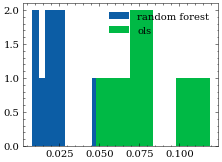

In [111]:
plt.hist(rf_rmse, label='random forest')
plt.hist(ols_rmse, label='ols')

plt.legend()

print(np.mean(rf_rmse))

### ADJUST LINEAR FOR MULTICOLINEARITY

In [81]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

X = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/wrangled_nthcomp_spectral_data.csv')

X = X[['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate']]

In [89]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [vif(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

mask = np.where(vif_info['VIF']<5)[0]

ols_cols = vif_info['Column'][mask]

print(list(ols_cols))
print()

vif_info

['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error']



,VIF,Column
0,1.113073,hardness_ratio
1,4.859469,diskbb_norm_before_error
2,1.537984,gamma_before_error
3,141.820636,nthcomp_norm_before_error
4,167.204664,net_source_count_rate


In [90]:
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/current_qpos.csv')

mask = np.where(np.isfinite(qpo_df['num_qpos']))
qpo_df = qpo_df.iloc[mask]

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/wrangled_nthcomp_spectral_data.csv')

merged_df = qpo_df.merge(spectral_df, left_on='full_id', right_on='full_ids').sample(frac=1, random_state=rs)
merged_df = merged_df.fillna(0)

# usual x values way 

# x values
x_vals = np.array([], dtype=float).reshape(0,3) 
arr_names =  ['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error'] #reduced_fit_stat
(hardness, disk_norms, gammas) = (normalize(np.array(merged_df[arr_name])) for arr_name in arr_names)

for a, b, c in zip(hardness, disk_norms, gammas): 
    new_arr = np.array([float(a), float(b), float(c)])
    x_vals = np.vstack([x_vals, new_arr])

# y values 
# normalize all freqs according to same function ---- THIS IS SO MESSY I KNOW...I AM SORRY 
combined_freqs = np.concatenate((merged_df['first_freq'], merged_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((merged_df['first_width'], merged_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((merged_df['first_norm'], merged_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(merged_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(merged_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(merged_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

x_vals, y_vals, num_qpos = utils.shuffle(x_vals, y_vals, np.array(qpo_df['num_qpos']), random_state=rs)

6
6
6
6
6
6
6
6
6
5
0.02738150808518315
0.07075047501299703
0.00010825088224469027


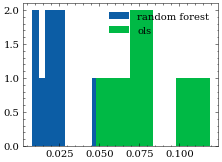

In [103]:
ols_rmse = []

skf = StratifiedKFold(n_splits=10)

counter = 1

for train_index, test_index in skf.split(x_vals, num_qpos):

    print(len(np.where(num_qpos[test_index]>0)[0]))

    X_train, X_test = x_vals[train_index], x_vals[test_index]
    y_train, y_test = y_vals[train_index], y_vals[test_index]

    regr = LinearRegression()
    regr.fit(X_train,y_train)

    predictions = regr.predict(X_test)

    rmse = mse_score(predictions, y_test, squared=False)

    ols_rmse.append(rmse)

plt.hist(rf_rmse, label='random forest')
plt.hist(ols_rmse, label='ols')

plt.legend()

print(np.mean(rf_rmse)+4.781*np.std(rf_rmse)/len(rf_rmse))
print(np.mean(ols_rmse)-4.781*np.std(ols_rmse)/len(ols_rmse)) # t value for df = 9, CL=0.9995% ... --> t might not be appropriate here

from scipy import stats

k, p = stats.ks_2samp(ols_rmse, rf_rmse, alternative='less')

print(p)

### one last check...dropping VIF > 5 spectral counts

In [104]:
spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/count_rates_initial_exploration/count_rates_transposed.csv')
qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/current_qpos.csv').fillna(0)


spectral_df.sort_values(by='full_id')
qpo_df.sort_values(by='full_id')

mask = np.where(np.isfinite(qpo_df['num_qpos']))

qpo_df = qpo_df.iloc[mask]

spectral_indices = []
for i in qpo_df['full_id']: 
    spectral_indices.append(np.where(spectral_df['full_id']==i)[0][0])

spectral_df = spectral_df.iloc[spectral_indices]

for i in ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']: 
    qpo_df = qpo_df.astype({i:float})

for i, j in zip(qpo_df['full_id'], spectral_df['full_id']): 
    if i!=j: 
        print('mis-match')
        print(i,j)
# package x values

bins = 25

x = []

for i in range(len(spectral_df.index)): 
    counts_row = np.array(spectral_df.iloc[[i]])[0][1:].astype(float) 
    
    rebin_factor = int(np.floor(len(counts_row)/bins))
    
    rebined = rebin(counts_row, rebin_factor)
    x.append(rebined)

x = np.array(x)


In [110]:
X 
vif_info = pd.DataFrame()
vif_info['VIF'] = [vif(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

mask = np.where(vif_info['VIF']<5)[0]

ols_cols = vif_info['Column'][mask]

print(list(ols_cols))

vif_info

[]


,VIF,Column
0,7.260145e+05,0
1,1.167849e+07,1
2,2.942924e+07,2
3,2.742357e+08,3
4,5.883597e+08,4
5,3.244485e+08,5
6,2.892301e+08,6
7,9.955799e+04,7
8,7.597974e+04,8
9,1.296642e+05,9
